# A multi-class quantum support vector machine on the wine dataset

In [32]:
from matplotlib import pyplot as plt
import numpy as np
from qiskit import Aer, execute
from qiskit.tools import job_monitor
from qiskit.aqua import QuantumInstance
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap, ZFeatureMap
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.components.multiclass_extensions import OneAgainstRest
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import MissingOptionalLibraryError
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import pandas as pd

## Dataset Preview

In [33]:
data = datasets.load_wine()
target = data.target
data = data.data

training_dataset_size = 10
testing_dataset_size = 10
class_labels = ["A", "B", "C"]

pd.DataFrame(data)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


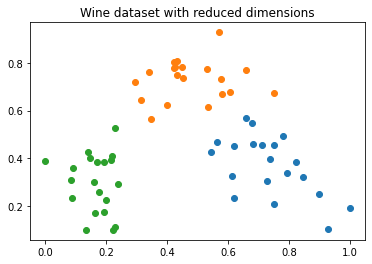

In [38]:
dim = 3
training_dataset_size = 20
testing_dataset_size = 10

sample_train, sample_test, label_train, label_test = train_test_split(data, target, random_state=10)

# Standardizing the dataset -- gaussian with unit variance and 0 mean
std = StandardScaler()
std.fit(sample_train)
sample_train = std.transform(sample_train)
sample_test = std.transform(sample_test)

# Using PCA to reduce no. of dimensions to 2 to match number of qubits
pca = PCA(dim)
pca.fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Scaling data to range from -1 to 1
minmax = MinMaxScaler()
minmax = minmax.fit(sample_train)
sample_train = minmax.transform(sample_train)
sample_test = minmax.transform(sample_test)

# Setting dataset size to number of training_dataset_size
training_input = {key: (sample_train[label_train == k, :])[:training_dataset_size] for k, key in enumerate(class_labels)}
test_input = {key: (sample_test[label_test == k, :])[:testing_dataset_size] for k, key in enumerate(class_labels)}

# Plotting data
for k in range(0, 3):
    plt.scatter(sample_train[label_train == k, 0][:training_dataset_size],
                sample_train[label_train == k, 1][:training_dataset_size])

plt.title("Wine dataset with reduced dimensions")
plt.show()

datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)

### ZZFeatureMap ansatz

In [39]:
backend = Aer.get_backend("qasm_simulator")
feature_map = ZZFeatureMap(dim, reps=2)
print(feature_map)

     ┌───┐┌──────────────┐                                                »
q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■────■──»
     ├───┤├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐  │  »
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──┼──»
     ├───┤├──────────────┤└───┘└───────────────────────────────┘└───┘┌─┴─┐»
q_2: ┤ H ├┤ U1(2.0*x[2]) ├───────────────────────────────────────────┤ X ├»
     └───┘└──────────────┘                                           └───┘»
«                                           ┌───┐»
«q_0: ───────────────────────────────────■──┤ H ├»
«                                        │  └───┘»
«q_1: ───────────────────────────────────┼────■──»
«     ┌───────────────────────────────┐┌─┴─┐┌─┴─┐»
«q_2: ┤ U1(2.0*(π - x[0])*(π - x[2])) ├┤ X ├┤ X ├»
«     └───────────────────────────────┘└───┘└───┘»
«              ┌──────────────┐                                       »
«q_0: ─────────┤ U1(2.0*x[0]) ├────────

In [40]:
svm = QSVM(feature_map, training_input, test_input, None, multiclass_extension=OneAgainstRest())
quantum_instance = QuantumInstance(backend, shots=8000)
result = svm.run(quantum_instance)

In [41]:
predicted_labels = svm.predict(datapoints[0])
predicted_classes = map_label_to_class_name(predicted_labels, svm.label_to_class)
print(f"Ground truth: {datapoints[1]}")
print(f"Prediction: {predicted_labels}")
print(" RESULTS Testing success ratio: ", result['testing_accuracy'])

Ground truth: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
Prediction: [0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 2 1 0 2 2 2 2 2 2 2 2 2 2]
 RESULTS Testing success ratio:  0.8275862068965517
